In [1]:
import uproot
import numpy as np
import torch
from collections import defaultdict
from util import get_layer, theta_func,create_layer_map
from reco import calculate_num_pixels_z_dependence
import matplotlib.pyplot as plot
import time
from collections import defaultdict
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)
from IPython.display import clear_output
from tqdm import tqdm
from torch import nn

Using device cuda:0


In [2]:
nn_input = torch.load("/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/momentum_prediction/sept_10_5k_n_input_slurm_test.pt")

/tmp/ipykernel_796603/562767274.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_input = torch.load("/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/d

In [3]:
import normflows as nf
import datetime
x = datetime.datetime.now()
today = x.strftime("%B_%d")
# particle = "pi"
particle = "mu"

# This data will be used for storing plots - today above works if you actually want today
# today = "July_26"

run_num = 7
run_num_str = str(run_num)

#NF Stuff

K = 8 #num flows

latent_size = 1 #dimension of PDF
hidden_units = 256 #nodes in hidden layers
hidden_layers = 26
context_size = 3 #conditional variables for PDF
num_context = 3

K_str = str(K)
batch_size= 2000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)
# model_date = "August_03"
# today = "August_03"
# model_path = "models/" + model_date + "/"
# checkdir(model_path)

model_path = "/hpc/group/vossenlab/rck32/NF_time_res_models/"

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")
model = model.to(device)
model_compile = torch.compile(model,mode = "reduce-overhead")
model_compile = model_compile.to(device)

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/normflows/core.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [4]:
layer_map, super_layer_map = create_layer_map()


def process_root_file(file_path):
    print("began processing")
    with uproot.open(file_path) as file:
        tree_HcalBarrelHits = file["events/HcalBarrelHits"]
        tree_MCParticles = file["events/MCParticles"]
        
        
        momentum_x_MC = tree_MCParticles["MCParticles.momentum.x"].array(library="np")
        momentum_y_MC = tree_MCParticles["MCParticles.momentum.y"].array(library="np")
        momentum_z_MC = tree_MCParticles["MCParticles.momentum.z"].array(library="np")
        
        z_pos = tree_HcalBarrelHits["HcalBarrelHits.position.z"].array(library="np")
        x_pos = tree_HcalBarrelHits["HcalBarrelHits.position.x"].array(library="np")
        energy = tree_HcalBarrelHits["HcalBarrelHits.EDep"].array(library="np")
        momentum_x = tree_HcalBarrelHits["HcalBarrelHits.momentum.x"].array(library="np")
        momentum_y = tree_HcalBarrelHits["HcalBarrelHits.momentum.y"].array(library="np")
        momentum_z = tree_HcalBarrelHits["HcalBarrelHits.momentum.z"].array(library="np")
        hit_time = tree_HcalBarrelHits["HcalBarrelHits.time"].array(library="np")
        mc_hit_idx = file["events/_HcalBarrelHits_MCParticle/_HcalBarrelHits_MCParticle.index"].array(library="np")  # Add PDG code for particle identification
        print("finished loading branches")
        
        processed_data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
        
        for event_idx in tqdm(range(len(z_pos))):
            energy_per_layer_particle = defaultdict(lambda: defaultdict(float))
            first_hit_per_layer_particle = defaultdict(dict)
            primary_momentum = (momentum_x_MC[event_idx][0],
                            momentum_y_MC[event_idx][0],
                            momentum_z_MC[event_idx][0])
            primary_momentum_mag = np.linalg.norm(primary_momentum)
            # First pass: collect first hit data and calculate energy per layer per particle
            for hit_idx in range(len(z_pos[event_idx])):
                z = z_pos[event_idx][hit_idx]
                x = x_pos[event_idx][hit_idx]
                e = energy[event_idx][hit_idx]
                momentum = (momentum_x[event_idx][hit_idx],
                            momentum_y[event_idx][hit_idx],
                            momentum_z[event_idx][hit_idx])
                momentum_mag = np.linalg.norm(momentum)
                theta = theta_func(momentum_x[event_idx][hit_idx], momentum_y[event_idx][hit_idx], momentum_z[event_idx][hit_idx])
                layer = get_layer(x)
                particle_id = mc_hit_idx[event_idx][hit_idx]
                
                energy_per_layer_particle[layer][particle_id] += e
                
                if layer not in first_hit_per_layer_particle or particle_id not in first_hit_per_layer_particle[layer]:
                    first_hit_per_layer_particle[layer][particle_id] = {
                        "z_pos": z,
                        "x_pos": x,
                        "momentum": momentum_mag,
                        "primary_momentum": primary_momentum_mag,
                        "theta": theta,
                        "time": hit_time[event_idx][hit_idx],
                        "mc_hit_idx": particle_id
                    }
            
            
            # Second pass: process first hit with total layer energy per particle
            for layer, particle_data in first_hit_per_layer_particle.items():
                for particle_id, hit_data in particle_data.items():
                    layer_particle_energy = energy_per_layer_particle[layer][particle_id]
                    num_pixels = calculate_num_pixels_z_dependence(layer_particle_energy, hit_data["z_pos"])
#                     print(f"layer:\t\t{layer}\t|\tparticle id:\t{particle_id}\t|\tnum_pixels:\t{num_pixels}")
                    hit_data["num_pixels"] = int(np.floor(num_pixels))
                    hit_data["layer_energy"] = layer_particle_energy  # Store total layer energy for this particle
                    processed_data[event_idx][layer][particle_id.item()] = hit_data
    
    print("finished processing")
    return processed_data

In [5]:
pref = "/hpc/group/vossenlab/rck32/"
# processed_data = process_root_file(pref + "eic/work_eic/root_files/September_3/sector_scint/run_1_pip_0_8_10GeV_theta_90_500events.edm4hep.root")
# processed_data = process_root_file(pref + "eic/work_eic/root_files/September_3/sector_scint/run_1_mum_0_8_10GeV_theta_90_500events.edm4hep.root")
processed_data = process_root_file(pref + "eic/work_eic/root_files/September_3/sector_scint/run_1_n_0_8_10GeV_theta_90_5kevents.edm4hep.root")
# nn_input, nn_output = prepare_nn_input(processed_data, normalizing_flow_model)
# prediction_input, prediction_output = prepare_prediction_input(nn_input, nn_output)

began processing
finished loading branches


100%|██████████| 5000/5000 [00:25<00:00, 198.84it/s]

finished processing


In [6]:
def prepare_nn_input(processed_data, normalizing_flow, batch_size=1024):
    flattened_data = []
    event_indices = []
    layer_indices = []
    particle_indices = []

    final_event_indices = []
    final_layer_indices = []
    final_particle_indices = []
    
    momentum_list = []
    
    context_list = []
    running_pixel_idx = 0
    for event_idx, event_data in processed_data.items():
        for layer, layer_data in event_data.items():
            for particle_id, particle_data in layer_data.items():
                primary_momentum = particle_data["primary_momentum"]
                context = torch.tensor([particle_data['z_pos'], particle_data['theta'], particle_data['momentum']], dtype=torch.float32).repeat(particle_data['num_pixels'], 1)
                flattened_data.append(torch.tensor([particle_data['time'], particle_data['num_pixels']]).repeat(particle_data['num_pixels'],1))
                context_list.append(context)
                for pixel_repeat_idx in range(particle_data['num_pixels']):
                    final_event_indices.append(event_idx)
                    final_layer_indices.append(layer)
                    final_particle_indices.append(particle_id)
                    momentum_list.append(primary_momentum.item())
    all_context = torch.cat(context_list).to(device)
    all_time_pixels = torch.cat(flattened_data)
    # Batch the flattened data
    max_its = int(np.ceil(all_context.shape[0] / batch_size))
    sampled_data = []
    print("Beginning sampling process")
    for batch_idx in tqdm(range(max_its)):
        begin = batch_idx * batch_size
        data_left = all_context.shape[0] - (batch_idx * batch_size)
        end = min(begin + batch_size,begin + data_left)
        add_times = all_time_pixels[begin:end]
        context_batch = all_context[begin:end].to(device)
        with torch.no_grad():
            samples = abs(normalizing_flow.sample(num_samples=context_batch.shape[0], context=context_batch)[0]).squeeze(1)
        adjusted_times = samples.detach().cpu() + add_times[:,0]
        sampled_data.extend(adjusted_times)
    # Reorganize sampled data
    nn_input = defaultdict(lambda: defaultdict(list))
    nn_output = defaultdict(lambda: defaultdict(list))
    print("Beginning reorganization process")
    for i, (event, layer, particle) in enumerate(zip(final_event_indices, final_layer_indices, final_particle_indices)):
        nn_input[event][layer].append(sampled_data[i])
        nn_output[event][layer].append(torch.Tensor([momentum_list[i]]))
    return nn_input, nn_output

In [7]:
begin = time.time()
nn_input, nn_output = prepare_nn_input(processed_data, model_compile,batch_size = 50000)
end = time.time()

Beginning sampling process


100%|██████████| 1220/1220 [14:28<00:00,  1.40it/s]


Beginning reorganization process


In [8]:
print(f"rate: {(end - begin) / 5000} seconds / event")

rate: 0.24599914326667785 seconds / event


In [9]:
def prepare_prediction_input(nn_input, nn_output):
    #note - some events do not have dictionaries in nn_input due to being empty
    #need to skip over these and condense tensor
    prediction_input = torch.ones(len(nn_input),28,10) * 999
    prediction_output = torch.ones(len(nn_input)) * 999
    
    input_dict = defaultdict(lambda: defaultdict(list))
    output_dict = {}
    curr_event_num = 0
    for event_idx in tqdm(list(nn_input)):
        event_input = []
        set_output = False
        layer_keys = nn_input[event_idx].keys()
        for layer in range(28):
            if(layer in layer_keys):
                layer_times = torch.tensor(sorted(nn_input[event_idx][layer]))
                # Pad or truncate to exactly 10 times per layer
                if len(layer_times) < 10:
                    padding = torch.full((10 - len(layer_times),), float(999))
                    layer_times = torch.cat([layer_times, padding])
                if(not set_output):
                    prediction_output[curr_event_num] = nn_output[event_idx][layer][0]
                    set_output = True
            else:
                layer_times = torch.full([28],999)

            prediction_input[curr_event_num][layer] = layer_times[:10]
        curr_event_num += 1
    return prediction_input, prediction_output


In [ ]:
prediction_input, prediction_output= prepare_prediction_input(nn_input,nn_output)

 45%|████▌     | 2251/4979 [10:55<23:40,  1.92it/s] 

In [14]:
class Predictor(nn.Module):
    """
    Prediction network
    """
    def __init__(self, input_size=280, num_classes=2, hidden_dim = 512, num_layers = 10):
        super(Predictor, self).__init__()
        self.layer = nn.Sequential()
        for i in range(num_layers):
            if(i == 0):
                self.layer.append(
                nn.Linear(input_size, hidden_dim)
                )
                self.layer.append(
                    nn.LeakyReLU(inplace=True)
                )
            elif(i == num_layers - 1):
                self.layer.append(
                nn.Linear(hidden_dim, num_classes)
                )
            else:
                self.layer.append(
                    nn.Linear(hidden_dim, hidden_dim)
                )
                self.layer.append(
                    nn.LeakyReLU(inplace=True)
                )
        self.name = "Predictor"
#         self.double()
        
    def forward(self, h):
        c = self.layer(h)
        return c
    
    # @property
    def name(self):
        """
        Name of model.
        """
        return self.name

In [15]:
from torch import nn
from reco import Predictor
num_layers = 28
num_pixels_per_layer = 10
model = Predictor(input_size=num_layers * num_pixels_per_layer, num_classes=1, hidden_dim = 280 * 2, num_layers = 20)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [23]:
def train(predictor, train_data,nn_output,optimizer,device, num_epochs = 18, batch_size = 100, show_progress = True):
    
    criterion = nn.MSELoss()
    predictor.train()
    total_data_points = train_data.shape[0]
    num_it = total_data_points // batch_size

    show_progress = True
    loss_hist = []
    curr_losses = []
    for i in range(num_epochs):
        clear_output(wait=True)
        print(f"Training epoch #{i}")
        epoch_hist = np.array([])
        val_epoch_hist = np.array([])
        with tqdm(total=num_it, position=0, leave=True) as pbar:
            for it in range(num_it):
                optimizer.zero_grad()
                begin = it * batch_size
                end = min((begin + batch_size),(total_data_points - begin))
                context_inputs = train_data[begin:end].flatten(start_dim = 1).to(device)
                expected_outputs = nn_output[begin:end].to(device)
                outputs = predictor(context_inputs)
                print(f"outputs: {outputs}")
                print(f"expected outputs: {expected_outputs}")
                loss = criterion(outputs, expected_outputs)
                # Do backprop and optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                # Log loss
                if~(torch.isnan(loss)):
                    curr_losses.append(loss.to('cpu').data.numpy())
                    if(not (it % 5)):
                        loss_hist.append(sum(curr_losses) / len(curr_losses))
                        curr_losses = []
                if(show_progress):
                    pbar.update(1)
        

    print('Finished Training')
    return loss_hist

In [ ]:
loss_hist = train(model,prediction_input,prediction_output,optimizer,device,num_epochs = 1, batch_size = 128)

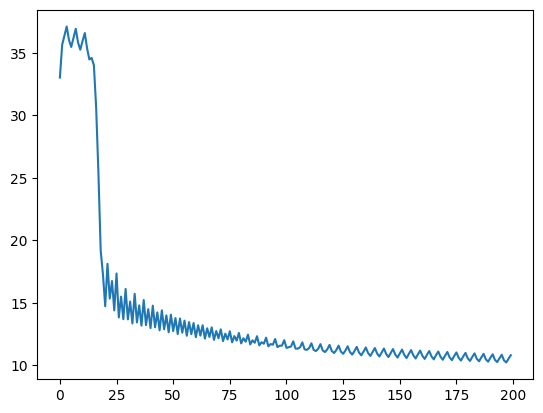

In [22]:
plot.plot(loss_hist);

In [2]:
import torch

In [7]:
test_input = torch.load("./data/momentum_prediction/sept_12_5k_n_input_slurm_0.pt")
test_output = torch.load("./data/momentum_prediction/sept_12_5k_n_output_slurm_0.pt")


/tmp/ipykernel_1933968/1021749622.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_input = torch.load("./data/momentum_prediction/sept_12_5k_n_input_slurm_0.pt")
/tm

In [8]:
test[101]

tensor([[ 10.8212,  11.2180,  11.5162,  11.5445,  11.6383,  11.6385,  11.6458,
          11.6660,  11.6771,  11.6923],
        [ 11.3897,  11.4625,  11.4850,  11.5092,  11.5183,  11.5553,  11.5785,
          11.5838,  11.5890,  11.6200],
        [ 10.9289,  10.9530,  10.9582,  10.9875,  11.0065,  11.0440,  11.0632,
          11.0725,  11.0819,  11.1070],
        [ 10.9927,  11.0114,  11.0218,  11.0351,  11.0370,  11.0497,  11.1218,
          11.1261,  11.1359,  11.1456],
        [ 10.7856,  10.8954,  11.1215,  11.1651,  11.1964,  11.1969,  11.2200,
          11.2362,  11.2424,  11.2574],
        [ 11.1248,  11.2034,  11.2405,  11.2592,  11.2644,  11.3100,  11.3236,
          11.3243,  11.3405,  11.3444],
        [ 11.5502,  11.6144,  11.6400,  11.7329,  11.7688,  11.8240,  11.8526,
          11.8655,  11.8658,  11.8765],
        [ 11.5905,  11.6553,  11.7269,  11.7804,  11.8270,  11.9834,  12.0566,
          12.1126,  12.1142,  12.2012],
        [ 11.6735,  11.7231,  11.7462,  11.8555,

In [21]:
test_output[107]

tensor(4.1287)

In [22]:
test_input[107]

tensor([[999.0000, 999.0000, 999.0000, 999.0000, 999.0000, 999.0000, 999.0000,
         999.0000, 999.0000, 999.0000],
        [999.0000, 999.0000, 999.0000, 999.0000, 999.0000, 999.0000, 999.0000,
         999.0000, 999.0000, 999.0000],
        [999.0000, 999.0000, 999.0000, 999.0000, 999.0000, 999.0000, 999.0000,
         999.0000, 999.0000, 999.0000],
        [999.0000, 999.0000, 999.0000, 999.0000, 999.0000, 999.0000, 999.0000,
         999.0000, 999.0000, 999.0000],
        [ 16.9103,  17.6764,  18.0900,  18.1883,  18.2154,  18.6976,  20.6132,
          21.2458,  22.6018,  23.2951],
        [ 20.9510,  20.9725,  21.0208,  21.6770,  21.9571,  22.2717,  22.5472,
          22.8347,  22.9454,  23.6713],
        [ 18.3015,  18.7514,  18.8010,  19.0258,  19.0356,  19.1539,  19.2485,
          19.3906,  19.4158,  19.4383],
        [ 16.3187,  16.3503,  16.3561,  16.4729,  16.6279,  16.7275,  16.8192,
          16.8327,  16.8656,  16.9273],
        [ 17.2845,  18.5188,  18.9531,  20.1260,